Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says "YOUR ANSWER HERE" or `YOUR CODE HERE` and remove the `raise NotImplementedError()` lines. 

Code blocks starting with a `# tests` comment provide unit tests which have to run without errors in order to get full points. Be aware that there might be further 'secret' tests to check correct implementation! I.e. the provided unit tests are necessary but not sufficient for full points!

You are always welcome to add **additional plots, tests, or debug outputs**.
However, make sure to: **1) not break the automated tests**, and **2) switch off any excessive debug output** when you submit your notebook!

Please add your name and student ID below:

In [1]:
NAME = "Fabian Traxler"
STUDENT_ID = "1553958"

In [2]:
assert len(NAME) > 0, "Enter your name!"
assert len(STUDENT_ID) > 0, "Enter your student ID!"

# Intelligent Audio and Music Analysis Assignment 7

This assignment accounts for the last 50 points of the 3rd and last assignment block (100 points total)

Assignment is mainly **free form**, the goal is to apply what has been practiced so far. For implementing assignment 7, best practice is to follow the code structures from previous assignments and reuse as much code as possible (this makes it easier for us to review it). You can use any libraries, however, we recommend you use: madmom, librosa, pyTorch, etc. (the libraries we have used so far).


### GPU Support
Our JupyterHub, unfortunately, does not yet provide GPU support. Nevertheless, this assignemnt can be run as-is on JupyterHub, however training of the neural network will take a long time.

In order to speed up training if you are in a hurry, you can run this notebook on any local machine with GPU and cuda support, or alternatively use infrastructure like [Google colab](https://colab.research.google.com/) and drive, if you have a google account.

Simply upload your solved notebook and necessary other files like output model file back to JupyterHub for your submission.

In [3]:
import os
# This code block enables this notebook to run on google colab.
try:
    from google.colab import drive
    print('Running in colab...\n===================')
    COLAB = True
    !pip install madmom torch==1.4.0 torchvision==0.5.0 librosa --upgrade
    print('Installed dependencies!\n=======================')

    if not os.path.exists('data'):
        print('Downloading data...\n===================')
        !mkdir data
        !cd data
        !wget https://zenodo.org/record/45739/files/TUT-acoustic-scenes-2016-development.audio.1.zip?download=1
        !wget https://zenodo.org/record/45739/files/TUT-acoustic-scenes-2016-development.audio.2.zip?download=1
        !wget https://zenodo.org/record/45739/files/TUT-acoustic-scenes-2016-development.audio.3.zip?download=1
        !wget https://zenodo.org/record/45739/files/TUT-acoustic-scenes-2016-development.audio.4.zip?download=1
        !wget https://zenodo.org/record/45739/files/TUT-acoustic-scenes-2016-development.audio.5.zip?download=1
        !wget https://zenodo.org/record/45739/files/TUT-acoustic-scenes-2016-development.audio.6.zip?download=1
        !wget https://zenodo.org/record/45739/files/TUT-acoustic-scenes-2016-development.audio.7.zip?download=1
        !wget https://zenodo.org/record/45739/files/TUT-acoustic-scenes-2016-development.audio.8.zip?download=1
        !wget https://zenodo.org/record/45739/files/TUT-acoustic-scenes-2016-development.doc.zip?download=1
        !wget https://zenodo.org/record/45739/files/TUT-acoustic-scenes-2016-development.error.zip?download=1
        !wget https://zenodo.org/record/45739/files/TUT-acoustic-scenes-2016-development.meta.zip?download=1
            
        !wget https://zenodo.org/record/165995/files/TUT-acoustic-scenes-2016-evaluation.audio.1.zip?download=1
        !wget https://zenodo.org/record/165995/files/TUT-acoustic-scenes-2016-evaluation.audio.2.zip?download=1
        !wget https://zenodo.org/record/165995/files/TUT-acoustic-scenes-2016-evaluation.audio.3.zip?download=1
        !wget https://zenodo.org/record/165995/files/TUT-acoustic-scenes-2016-evaluation.doc.zip?download=1
        !wget https://zenodo.org/record/165995/files/TUT-acoustic-scenes-2016-evaluation.meta.zip?download=1
            
        !for file in *.*; do mv $file ${file%?download=1}; done
        
        !unzip "*.zip"
        !rm *.zip
        !cd ..

    print('===================\nMake sure you activated GPU support: Edit->Notebook settings->Hardware acceleration->GPU\n==================')
except:
    print('=======================\nNOT running in colab...\n=======================')
    COLAB = False

NOT running in colab...


## Audio Scene Classification

Your task is to implement a solution to an auditory scene detection challenge, precisely the DCASE 2016 Acoustic Scene Classification task. Details about the challenge are provided on the [task website](http://www.cs.tut.fi/sgn/arg/dcase2016/task-acoustic-scene-classification).
1. You are **free in the strategy that you apply** here and can also reuse and modify your implementation previous assignments, e.g., by modifying the architecture to handle clips of length 30 seconds.
2. **Follow the given evaluation strategies of the task**, in particular wrt. development and evaluation datasets and cross validation settings.
3. Consider **reducing the amount of data** in a reasonable way, if necessary.
4. **Compare your results** to the numbers reported on the task website and comment on you main findings.

Remark: The goal is not to outperform the state of the art, but to experiment with a classification task in the general audio domain. Therefore, you can apply your existing solutions from the music domain and reflect upon the capabilities and limitations of your approach.

The overall goal of this assignment is to implement the method in an elegant way and present your implementation in this notebook:
1. **Illustrate your chosen architecture** e.g. by printing the individual layers and the shapes of the forward function if you choose a neural network approach (as we have done in previous assignments).
2. **Use plots** to showcase features and evaluation results.
3. Output your **final performance** and set it into context.

The rough distribution of points is as follows:
* 10 Points data preprocessing and data handling
* 10 Points machine learning architecture (e.g. neural network and data loader)
* 10 Points training method and evaluation
* 10 Points results and conclusion
* 10 Points overall presentation throughout the notebook


# Task 1: Data Processing (10 Points)

If you work on JupyterHub, find the audiofiles in the shared folder as indicated in the cell below.
Think about **reasonable features** to use and extract them for the audio files.
The DCASE dataset is already split into **a development and an evaluation** set. The idea is to only use the evaluation set **once** at the very end when you are confident about your trained system.
Only use the development set to draw your train/valid/test splits from.
The dataset comes with **predefined splits** for four-fold cross-validation. Feel free to use your own training setup, but read and **follow the guidelines** that come in the documentation of the dataset!

**Note**: Check the readme files in the dataset folder for more details!!

In [4]:
import os
import numpy as np

np.random.seed(1234)

# get dataset path
dataset_path = os.path.join(os.environ['HOME'], 'shared', 'data', 'assignment_7')
if os.path.exists('data'):
    dataset_path = 'data'

development_path = os.path.join(dataset_path, 'TUT-acoustic-scenes-2016-development')
evaluation_path = os.path.join(dataset_path, 'TUT-acoustic-scenes-2016-evaluation')

development_audio_path = os.path.join(development_path, 'audio')
development_annotation_file = os.path.join(development_path, 'meta.txt')
development_error_file = os.path.join(development_path, 'error.txt')
split_definition_path = os.path.join(development_path, 'evaluation_setup')

evaluation_annotation_file = os.path.join(evaluation_path, 'meta.txt')
evaluation_audio_path = os.path.join(evaluation_path, 'audio')

data_file_clip_info = os.path.join(dataset_path, 'clip_info_final.csv')
data_file_annotations = os.path.join(dataset_path, 'annotations_final.csv')

# collect list of audio files:
development_audio_files = [af for af in os.listdir(development_audio_path) if af.endswith('.wav')]
evaluation_audio_files = [af for af in os.listdir(evaluation_audio_path) if af.endswith('.wav')]

dev_audio_total_count = len(development_audio_files)
eval_audio_total_count = len(evaluation_audio_files)

print(f'Total number of development audio files: {dev_audio_total_count}')
print(f'Total number of evaluation audio files: {eval_audio_total_count}')

Total number of development audio files: 1170
Total number of evaluation audio files: 390


### 1.1 Implementation

In [5]:
# Data Exploration 
## Check how the audio files and the annotations look like

audio_sample = development_audio_files[0]
print(audio_sample)

with open(development_annotation_file) as f:
    annotation_file = f.readline()
print(annotation_file)

a050_60_90.wav
audio/a001_0_30.wav	residential_area



As we can see the `development_audio_files` contain the filenames of every audio file and the `development_annotation_file` is a tab seperated file which contains every annotation for every audio file with the `audio` folder prefixed. This means we will add the `audio` folder to the audio_files in oder to evaluate the results in the end

#### Feature Extraction

In order to extract features a very similar approach to the one used in the baseline is used. Therefore, first the MFCC of the audio samples is extracted using a Frame size of 1764 frames (=40ms) and 882 Frame Hop Size (=20ms). Different to the baseline approach a Hann window was used as well as 96 Mel-Bands and 96 MFCCs.
Like in the baseline also the Delta (first derivative) and the acceleration (2nd derivative) is also calculated to generate even more expressive features.

In [6]:
# Put your data handling code here. 
# You can add additional cells below this one for structuring the notebook.
# Feel free to add markdown cells / plots / tests / etc. if it helps your presentation.

# YOUR CODE HERE
import warnings
warnings.simplefilter("ignore")
import librosa
import time
import scipy
import pickle

## Default Parameters
FRAME_SIZE = 1764
HOP_SIZE = 882
NUM_MEL_BANDS = 48
HANN_WINDOW = scipy.signal.hann

SAMPLE_RATE = 44100


def process_audio_files(file_list, 
                        path_to_files=development_audio_path, 
                        sample_rate=SAMPLE_RATE,
                        frame_size=FRAME_SIZE, 
                        hop_size=HOP_SIZE, 
                        num_mel_bands=NUM_MEL_BANDS,
                        window=HANN_WINDOW):
    """
    Process the Audio files and extract a MFCC for every file
    
    Args:
        file_list (list): File names
    
    Return:
        np.ndarray: MFCCs for every audio file in file_list
        np.ndarray: filenames with 'audio/' prefixed
    """
    file_names = []
    features = []
    
    # dataset recording specifications
    audio_len = 30
    
    
    for i, filename in enumerate(file_list):
        print("{}/{} files".format(i, len(file_list)), end="\r")
        try:
            filepath = os.path.join(path_to_files, filename)
            audio_stream, sr = librosa.load(filepath, sr=sample_rate, duration=audio_len)
            
            melgram = librosa.feature.melspectrogram(y=audio_stream, 
                                                     sr=sample_rate, 
                                                     hop_length=hop_size,
                                                     n_fft=frame_size, 
                                                     n_mels=num_mel_bands,
                                                     window=window(frame_size), center=True)
            log_melgram = librosa.power_to_db(melgram**2, ref=1)
            mfcc = librosa.feature.mfcc(S=log_melgram, n_mfcc=num_mel_bands)
            mfcc_delta = librosa.feature.delta(log_melgram)
            mfcc_acc = librosa.feature.delta(log_melgram, order=2)
            
            feature = feature_matrix = np.vstack((mfcc, mfcc_delta, mfcc_acc))
            
            file_names.append("audio/"+filename)
            features.append(feature)
        except Exception as e:
            print(e)
            print("Corrupt Audio File >>> Skipped File {}".format(filename))
    
    return np.asarray(features), np.asarray(file_names)

In [7]:
from sklearn.preprocessing import OneHotEncoder
def get_annotations(file_names, annotation_file, encoder=None):
    """
    Get all annotations for the provided filename and return an array of annotations with the same index as the file_names
    
    Args:
        file_names (list): Filenames for which to extract Annotations
        annotation_file (str): Path to the annotation_file, which is tab_seperated
    
    Return:
        np.ndarray: Array containing all the annotations as strings
    """
    with open(annotation_file) as f:
        annotation_list = f.read().split("\n")
    
    annotation_list = [ annotation.split("\t") for annotation in annotation_list if annotation != ""]
    annotation_dict = dict(annotation_list)
    tags = set(annotation_dict.values())

    annotations = [ [annotation_dict[file_name]] for file_name in file_names ]
    if not encoder:
        encoder = OneHotEncoder()
    annotations = encoder.fit_transform(annotations)
    
    return encoder, np.asarray(annotations.todense())



In [8]:
load = True # possibility to load extracted features to speed up notebook

if load:
    with open("features.pickle", "rb") as f:
        features = pickle.load(f)
    with open("filenames.pickle", "rb") as f:
        file_names = pickle.load(f)
    with open("annotations.pickle", "rb") as f:
        annotations = pickle.load(f)
    with open("encoder.pickle", "rb") as f:
        encoder = pickle.load(f)
else:
    start = time.time()
    features, file_names = process_audio_files(development_audio_files)
    print("\nFeature Extraction took {}s".format(time.time() - start))
    with open("features.pickle", "wb") as f:
        pickle.dump(features, f)
    with open("filenames.pickle", "wb") as f:
        pickle.dump(file_names,f)
        
    encoder, annotations = get_annotations(file_names, development_annotation_file)
    with open("annotations.pickle", "wb") as f:
        pickle.dump(annotations, f)
    with open("encoder.pickle", "wb") as f:
        pickle.dump(encoder, f)

#### Feature Visualizations

In the cell below we visualize the features extracted from the audio samples. Therefore we use the same method as in previous assignments to show a sectrogram. In this case we visualize the MFCCs as well as the delta and the acceleration (dela-2) for two samples from different classes. ´

Feature Shape >>>  (144, 1501)
File name >>>  audio/a050_60_90.wav
Annotation >>>  [['grocery_store']]


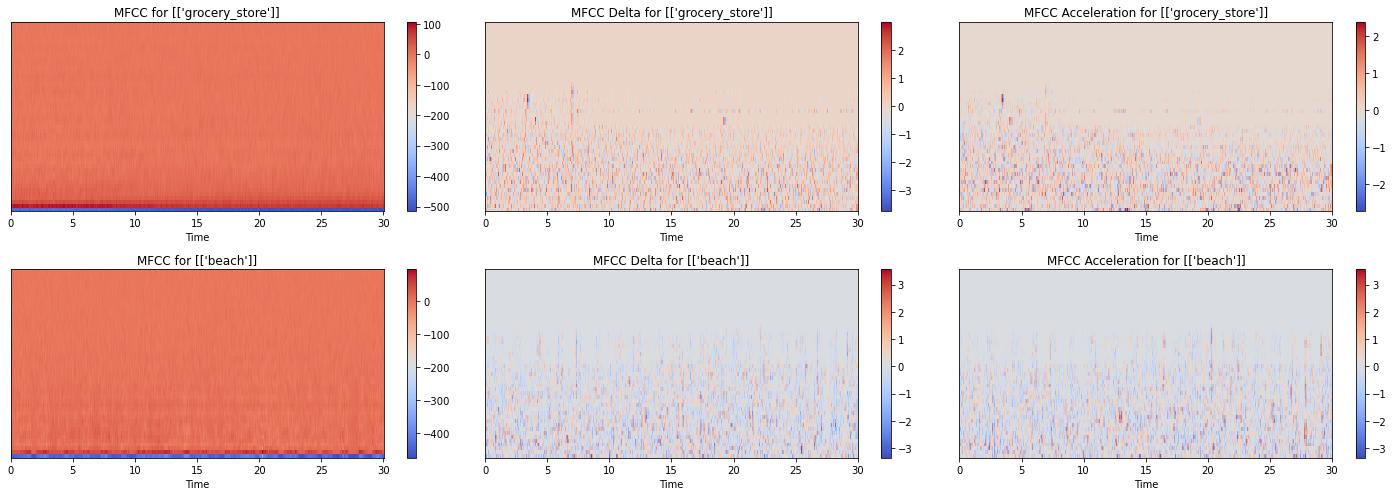

In [9]:
## Tests
import matplotlib.pyplot as plt
import librosa.display

sample_feature = features[0]
print("Feature Shape >>> ", features[0].shape)
print("File name >>> ", file_names[0])
print("Annotation >>> ", encoder.inverse_transform(annotations[0].reshape(1,-1)))

fig = plt.figure(figsize=(20, 7))

file = 0
ax = plt.subplot(231)
img = librosa.display.specshow(features[file,:NUM_MEL_BANDS,:], x_axis='time', ax=ax, sr=SAMPLE_RATE, hop_length=HOP_SIZE)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC for {}'.format(encoder.inverse_transform(annotations[file].reshape(1,-1))))

file = 0
ax = plt.subplot(232)
img = librosa.display.specshow(features[file,NUM_MEL_BANDS:NUM_MEL_BANDS*2,:], x_axis='time', ax=ax, sr=SAMPLE_RATE, hop_length=HOP_SIZE)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC Delta for {}'.format(encoder.inverse_transform(annotations[file].reshape(1,-1))))

file = 0
ax = plt.subplot(233)
img = librosa.display.specshow(features[file,NUM_MEL_BANDS*2:,:], x_axis='time', ax=ax, sr=SAMPLE_RATE, hop_length=HOP_SIZE)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC Acceleration for {}'.format(encoder.inverse_transform(annotations[file].reshape(1,-1))))


file = 1
ax = plt.subplot(234)
img = librosa.display.specshow(features[file,:NUM_MEL_BANDS,:], x_axis='time', ax=ax, sr=SAMPLE_RATE, hop_length=HOP_SIZE)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC for {}'.format(encoder.inverse_transform(annotations[file].reshape(1,-1))))

file = 1
ax = plt.subplot(235)
img = librosa.display.specshow(features[file,NUM_MEL_BANDS*2:NUM_MEL_BANDS*3,:], x_axis='time', ax=ax, sr=SAMPLE_RATE, hop_length=HOP_SIZE)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC Delta for {}'.format(encoder.inverse_transform(annotations[file].reshape(1,-1))))

file = 1
ax = plt.subplot(236)
img = librosa.display.specshow(features[file,NUM_MEL_BANDS*2:,:], x_axis='time', ax=ax, sr=SAMPLE_RATE, hop_length=HOP_SIZE)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC Acceleration for {}'.format(encoder.inverse_transform(annotations[file].reshape(1,-1))))

plt.tight_layout()
plt.show()

### 1.2 Discussion

Write down what choices you made regarding data structuring and feature extraction, feel free to refer to code/plots/etc. in cells above.

In this approach I used the last assignments as well as the baseline solution provided by the challenge team as source of inspiration. Therefore I used 96 Mel bands (same as in Assignment 6) and added additionally the Delta and Acceleration features in order account for typical temporal changes in an acoustic scence.

## Task 2: Machine Learning Approach (10 Points)

Implement your audio scene classification method here. You are free to use any approach you find appropriate. As a hint: the easiest way to succeed is to adapt the neural network approach from assignment 6 (or 5), since convolutional neural networks have been shown to work very well for this task, and you can start with a running code base.

### 2.1 Implementation

In order to learn better features using a CNN the input data is split into 3 parts - the MFCC, the Delta and the Acceleration. For the MFCCs 5 convolutional layers a used to learn the features and for the delta and acceleration only 3 layers each are used. After each Conv Layer, Batchnormalization, Max-Pooling and Elu is applied.

In [10]:
import torch.nn as nn
import torch.nn.functional as torch_func

DEFAULT_NUM_CLASSES = annotations.shape[1]

class AudioSceneClassificatinCNN(nn.Module):
    def __init__(self, debug=False, num_classes=DEFAULT_NUM_CLASSES):
        super(AudioSceneClassificatinCNN, self).__init__()
        self.debug = debug # use the debug flag again to produce shape outputs in the forward function.
        
        #initialize modules for neural network
        # YOUR CODE HERE
        kernel_size = (3,3)
        # train seperate networks for mfccs and mfcc delta
        self.conv1_mfcc = nn.Conv2d(1, 64, kernel_size=kernel_size, padding=1)
        self.conv1_mfcc_bn = nn.BatchNorm2d(64) 
        self.conv2_mfcc = nn.Conv2d(64, 128, kernel_size=kernel_size, padding=1)
        self.conv2_mfcc_bn = nn.BatchNorm2d(128) 
        self.conv3_mfcc = nn.Conv2d(128, 128, kernel_size=kernel_size, padding=1)
        self.conv3_mfcc_bn = nn.BatchNorm2d(128) 
        self.conv4_mfcc = nn.Conv2d(128, 128, kernel_size=kernel_size, padding=1)
        self.conv4_mfcc_bn = nn.BatchNorm2d(128) 
        self.conv5_mfcc = nn.Conv2d(128, 64, kernel_size=kernel_size, padding=1)
        self.conv5_mfcc_bn = nn.BatchNorm2d(64) 
        
        self.conv1_delta = nn.Conv2d(1, 32, kernel_size=kernel_size, padding=1)
        self.conv1_delta_bn = nn.BatchNorm2d(32) 
        self.conv2_delta = nn.Conv2d(32, 32, kernel_size=kernel_size, padding=1)
        self.conv2_delta_bn = nn.BatchNorm2d(32) 
        self.conv3_delta = nn.Conv2d(32, 16, kernel_size=kernel_size, padding=1)
        self.conv3_delta_bn = nn.BatchNorm2d(16) 

        self.conv1_acc = nn.Conv2d(1, 32, kernel_size=kernel_size, padding=1)
        self.conv1_acc_bn = nn.BatchNorm2d(32) 
        self.conv2_acc = nn.Conv2d(32, 32, kernel_size=kernel_size, padding=1)
        self.conv2_acc_bn = nn.BatchNorm2d(32) 
        self.conv3_acc = nn.Conv2d(32, 16, kernel_size=kernel_size, padding=1)
        self.conv3_acc_bn = nn.BatchNorm2d(16) 
        
        self.dense = nn.Linear(96, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        if self.debug: print(x.shape)
        # train seperate networks for mfccs and mfcc delta
        x_mfcc = x[:,:,:48,:] 
        x_delta = x[:,:,48:96,:]
        x_acc = x[:,:,96:,:]

        x_mfcc = self.conv1_mfcc(x_mfcc)
        x_mfcc = self.conv1_mfcc_bn(x_mfcc)
        x_mfcc = torch_func.max_pool2d(x_mfcc, (2,4))
        x_mfcc = torch_func.elu(x_mfcc)

        x_mfcc = self.conv2_mfcc(x_mfcc)
        x_mfcc = self.conv2_mfcc_bn(x_mfcc)
        x_mfcc = torch_func.max_pool2d(x_mfcc, (2,4))
        x_mfcc = torch_func.elu(x_mfcc)

        x_mfcc = self.conv3_mfcc(x_mfcc)
        x_mfcc = self.conv3_mfcc_bn(x_mfcc)
        x_mfcc = torch_func.max_pool2d(x_mfcc, (2,4))
        x_mfcc = torch_func.elu(x_mfcc)
        
        x_mfcc = self.conv4_mfcc(x_mfcc)
        x_mfcc = self.conv4_mfcc_bn(x_mfcc)
        x_mfcc = torch_func.max_pool2d(x_mfcc, (2,5))
        x_mfcc = torch_func.elu(x_mfcc)
        
        x_mfcc = self.conv5_mfcc(x_mfcc)
        x_mfcc = self.conv5_mfcc_bn(x_mfcc)
        x_mfcc = torch_func.max_pool2d(x_mfcc, (3,4))
        x_mfcc = torch_func.elu(x_mfcc)
        if self.debug: print(x_mfcc.shape)
            
        x_delta = self.conv1_delta(x_delta)
        x_delta = self.conv1_delta_bn(x_delta)
        x_delta = torch_func.max_pool2d(x_delta, (4,5))
        x_delta = torch_func.elu(x_delta)

        x_delta = self.conv2_delta(x_delta)
        x_delta = self.conv2_delta_bn(x_delta)
        x_delta = torch_func.max_pool2d(x_delta, (4,15))
        x_delta = torch_func.elu(x_delta)

        x_delta = self.conv3_delta(x_delta)
        x_delta = self.conv3_delta_bn(x_delta)
        x_delta = torch_func.max_pool2d(x_delta, (3,20))
        x_delta = torch_func.elu(x_delta)
        
        if self.debug: print(x_delta.shape)
            
        x_acc = self.conv1_acc(x_acc)
        x_acc = self.conv1_acc_bn(x_acc)
        x_acc = torch_func.max_pool2d(x_acc, (4,5))
        x_acc = torch_func.elu(x_acc)

        x_acc = self.conv2_acc(x_acc)
        x_acc = self.conv2_acc_bn(x_acc)
        x_acc = torch_func.max_pool2d(x_acc, (4,15))
        x_acc = torch_func.elu(x_acc)

        x_acc = self.conv3_acc(x_acc)
        x_acc = self.conv3_acc_bn(x_acc)
        x_acc = torch_func.max_pool2d(x_acc, (3,20))
        x_acc = torch_func.elu(x_acc)
        
        if self.debug: print(x_acc.shape)
            
        x = torch.cat((x_mfcc, x_delta, x_acc), 1)
        if self.debug: print(x.shape)
        x = x.view(-1, 96)
        y = self.dense(x)
        y = torch_func.sigmoid(y)
        return y

In [11]:
print(AudioSceneClassificatinCNN())

AudioSceneClassificatinCNN(
  (conv1_mfcc): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_mfcc_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_mfcc): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_mfcc_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_mfcc): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_mfcc_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_mfcc): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_mfcc_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5_mfcc): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_mfcc_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_delta): Conv2d(1, 32, kernel_size=(3, 3), stride=(

### 2.2 Discussion
Write down your choices and findings. Feel free to refer to code/plots/etc. in cells above.

As we can see in the output above the network consists of multiple convolutional layers all followed by Batchnormalization, Max-Pooling and the Elu Activation Function. The network is split into three parts since we would like to learn high level features for every feature set we extracted from the audio files (MFCC, MFCC Delta, MFCC Acceleration)

## Task 3: Training, Inference, and Evaluation (10 Points)

Depending on your choices for the machine learning model, implement the appropriate code to train and test it.
For developing and training the model only use the development set. 

### 3.1 Implementation

#### Dataloader

In order to validate the model performance during training the data is split into a train a and a validation subset. The size of the validation set is 15% of the whole training data and the rest is used for model training

In [12]:
# Put your trainin and evaluation code in the cells below.
# You can add additional cells below this one for structuring the notebook.
# Feel free to add markdown cells / plots / tests / etc. if it helps your presentation.

# YOUR CODE HERE
from sklearn.model_selection import train_test_split
# train and val split
train_idxs, val_idxs = train_test_split(range(len(features)), test_size=0.15)

In [13]:
from torch.utils.data import Dataset

class AudioScenceSet(Dataset):
    def __init__(self, features, targets):
        super(AudioScenceSet, self).__init__()
        self.features = features.astype(np.float32)
        self.targets = targets.astype(np.float32)
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return(torch.tensor(self.features[idx]), torch.tensor(self.targets[idx]))

In [14]:
train_feats = features[train_idxs]
train_targs = annotations[train_idxs]

val_feats = features[val_idxs]
val_targs = annotations[val_idxs]

#### Training

For Training the functions of the last assignments are reused and enhanced to also show the accurary of the validation data after each epoch

In [15]:
# helper functions for training - you can copy and modify from the last assignment

from time import time as get_time
from sklearn.metrics import accuracy_score

def train_epoch_cnn(model, train_loader, optimizer, args):
    # performs one epoch of training
    """
    Training loop for one epoch of NN training.
    Within one epoch, all the data is used once, we use mini-batch gradient descent.
    :param model: The model to be trained
    :param train_loader: Data provider
    :param optimizer: Optimizer (Gradient descent update algorithm)
    :param args: NN parameters for training and inference
    :return:
    """
    
    model.train()  # set model to training mode (activate dropout layers for example)
    t = get_time() # we measure the needed time
    for batch_idx, (data, target) in enumerate(train_loader):  # iterate over training data
        data, target = data.to(args.device), target.to(args.device)  # move data to device (GPU) if necessary
        optimizer.zero_grad()  # reset optimizer
        output = model(data)   # forward pass: calculate output of network for input
        target = np.argmax(target, axis=1)
        loss = torch_func.cross_entropy(output, target)  # calculate loss
        loss.backward()  # backward pass: calculate gradients using automatic diff. and backprop.
        optimizer.step()  # udpate parameters of network using our optimizer
        cur_time = get_time()
        # print some outputs if we reached our logging intervall
        if cur_time - t > args.log_interval or batch_idx == len(train_loader)-1:  
            print('[{}/{} ({:.0f}%)]\tloss: {:.6f}, took {:.2f}s'.format(
                       batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item(),cur_time - t))
            t = cur_time

def test_cnn(model, test_loader, args):
    # runs inference over the test dataset and calculates overall loss (for validation and testing)
    """
    Function wich iterates over test data (eval or test set) without performing updates and calculates loss.
    :param model: The model to be tested
    :param test_loader: Data provider
    :param args: NN parameters for training and inference
    :return: cumulative test loss
    """
    model.eval()  # set model to inference mode (deactivate dropout layers for example)
    predictions = []
    targets = []
    test_loss = 0  # init overall loss
    with torch.no_grad():  # do not calculate gradients since we do not want to do updates
        for data, target in test_loader:  # iterate over test data
            data, target = data.to(args.device), target.to(args.device)  # move data to device 
            output = model(data) # forward pass
            # claculate loss and add it to our cumulative loss
            test_loss += torch_func.binary_cross_entropy(output, target, reduction='sum').item()
            predictions.extend(np.argmax(output, axis=1).numpy())
            targets.extend(np.argmax(target, axis=1).numpy())

    test_loss /= len(test_loader.dataset)  # calc mean loss
    print('Average eval loss: {:.4f}'.format(test_loss, len(test_loader.dataset)))
    accuracy = round(accuracy_score(targets, predictions),2)
    print("Average Evaluation Accuracy: {}\n".format(accuracy))
    return test_loss


def inference_cnn(model, data, args):
    # runs inference over a single instance (for actual use of the model on real data)
    """
    Function calculating the actual output of the network, given some input.
    :param model: The network to be used
    :param data: Data for which the output should be calculated
    :param args: NN parameters for training and inference
    :return: output of network
    """
    model.eval()   # set model to inference mode
    data = torch.from_numpy(data) 
    data = data.unsqueeze(0)
    data = data.to(args.device) # move input to device
    with torch.no_grad(): # do not calculate gradients
        output = model(data).cpu()
    return output.numpy().squeeze(0)

In [16]:
# training hyper parameters: go with these defaults at first
CNN_MODEL_NAME = 'scene_classifier_'

# Helper class for neural network hyper-parameters
# Do not change them until you have a working model
class Args:
    pass

DEFAULT_ARGS = Args()
# general params
DEFAULT_ARGS.use_cuda = True
DEFAULT_ARGS.seed = 1

# architecture setup
DEFAULT_ARGS.batch_size = 96
DEFAULT_ARGS.out_num = DEFAULT_NUM_CLASSES

# optimizer parameters
DEFAULT_ARGS.lr = 0.01

# training protocoll
DEFAULT_ARGS.max_epochs = 1000
DEFAULT_ARGS.patience = 3
DEFAULT_ARGS.refinement = 2  # restart training after patience runs out with the best model, decrease lr by...
DEFAULT_ARGS.lr_fac = 0.1    # ... the learning rate factor lr_fac: lr_new = lr_old*lr_fac
DEFAULT_ARGS.log_interval = 10  # seconds

In [17]:
# main training loop, start with your implementation from the last assignment and modify to accompany 
# the leraning rate scedule.
from torch.optim import SGD
import torch

def train_cnn(smoke_test=False, load_model=False, args=DEFAULT_ARGS):
    """
    Run CNN training using the datasets.
    :param smoke_test: bool, run a quick pseudo training to check if everything works
    :param load_model: bool or string, load the last trained model (if set to True), or the model in file (string)
    :param args: hyperparameters for training
    :return: trained model
    """
    if smoke_test:  # set hyperparameters to run a quick pseudo training...
        max_epochs = 2
        use_train_feats = train_feats[:2]
        use_valid_feats = val_feats[:2]
        
        use_train_targs = train_targs[:2]
        use_valid_targs = val_targs[:2]
        
    else:
        max_epochs = args.max_epochs
        use_train_feats = train_feats
        use_valid_feats = val_feats
        
        use_train_targs = train_targs
        use_valid_targs = val_targs
    
    # 1) setup pytorch
    use_cuda = args.use_cuda and torch.cuda.is_available()
    torch.manual_seed(args.seed)
    args.device = torch.device("cuda" if use_cuda else "cpu")
    # 2) create model and optimizer, use Adam
    model = AudioSceneClassificatinCNN(debug=smoke_test).to(args.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    # 3) setup datasets and loaders for training, evaluation and testing
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {'num_workers': 0}
    train_loader = torch.utils.data.DataLoader(AudioScenceSet(use_train_feats, use_train_targs),
                                               batch_size=args.batch_size, shuffle=True, **kwargs)
    valid_loader = torch.utils.data.DataLoader(AudioScenceSet(use_valid_feats, use_valid_targs),
                                               batch_size=args.batch_size, shuffle=False, **kwargs)
    
    # find model filename for last run, and next free filename for model
    model_cnt = 0
    new_model_file = os.path.join(CNN_MODEL_NAME + str(model_cnt) + '.model')
    last_model_file = None
    while os.path.exists(new_model_file):
        model_cnt += 1
        last_model_file = new_model_file
        new_model_file = os.path.join(CNN_MODEL_NAME + str(model_cnt) + '.model')
    if load_model is None or not load_model:  # let's train
        # train model for max_epochs epochs, output loss after log_intervall seconds.
        # for each epoch run once on validation set, 
        # write model to disk if validation loss decreased
        # if validation loss increased, check for early stopping with patience and refinements
        # after model is trained, perform a run on test set and output loss (don't forget to reload best model!)
        
        # YOUR CODE HERE
        best_valid_loss = 9999.
        cur_patience = args.patience  # we keep track of our patience here.
        cur_refinement = args.refinement
        cur_lr = args.lr
        print('Training CNN...')
        start_t = get_time()
        for epoch in range(max_epochs):
            train_epoch_cnn(model, train_loader, optimizer, args)
            valid_loss = test_cnn(model, valid_loader, args)
            if valid_loss < best_valid_loss:
                if not smoke_test: torch.save(model.state_dict(), new_model_file)
                best_valid_loss = valid_loss
                cur_patience = args.patience
            else:
                if cur_patience <= 0:
                    if cur_refinement <= 0:
                        print("End of Training")
                        break
                    else:
                        print("Reload best Model and reduce Learning Rate")
                        lr_new = cur_lr*args.lr_fac
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr_new
                        model.load_state_dict(torch.load(new_model_file, map_location=args.device))
                        cur_refinement -= 1
                        cur_patience = args.patience
                else:
                    cur_patience -= 1
                    print("Loss did not decrease (Patience: {})\n".format(cur_patience))
                    
                
        print('Trainig took: {:.2f}s for {} epochs'.format(get_time()-start_t, epoch))
        
        
    else:  # we should just load a model...
        if not isinstance(load_model, str) or not os.path.exists(load_model):
            load_model = last_model_file
        if load_model is None or not os.path.exists(load_model):
            print('Model file not found, unable to load...')
        else:
            model.load_state_dict(torch.load(load_model, map_location=args.device))
            print("Model file loaded: {}".format(load_model))
    
    return model


In [18]:
# tests
model = train_cnn(smoke_test=True)  # just a quick run to check everything is working

print('All tests successful!')

Training CNN...
torch.Size([2, 1, 144, 1501])
torch.Size([2, 64, 1, 1])
torch.Size([2, 16, 1, 1])
torch.Size([2, 16, 1, 1])
torch.Size([2, 96, 1, 1])
[0/2 (0%)]	loss: 2.864457, took 0.44s
torch.Size([2, 1, 144, 1501])
torch.Size([2, 64, 1, 1])
torch.Size([2, 16, 1, 1])
torch.Size([2, 16, 1, 1])
torch.Size([2, 96, 1, 1])
Average eval loss: 88.9645
Average Evaluation Accuracy: 0.5

torch.Size([2, 1, 144, 1501])
torch.Size([2, 64, 1, 1])
torch.Size([2, 16, 1, 1])
torch.Size([2, 16, 1, 1])
torch.Size([2, 96, 1, 1])
[0/2 (0%)]	loss: 2.163806, took 0.47s
torch.Size([2, 1, 144, 1501])
torch.Size([2, 64, 1, 1])
torch.Size([2, 16, 1, 1])
torch.Size([2, 16, 1, 1])
torch.Size([2, 96, 1, 1])
Average eval loss: 55.2620
Average Evaluation Accuracy: 0.5

Trainig took: 1.50s for 1 epochs
All tests successful!


In [19]:
SUBMISSION = True

In [20]:
if not SUBMISSION:
    model = train_cnn()
else:
    model = train_cnn(load_model=True)
    # you can set a specific model file for submission, if you trained multiple models using e.g.:
    # load_model='best_cnn_adt.model'

Model file loaded: scene_classifier_1.model


### 3.2 Discussion
Write down your choices and findings. Feel free to refer to code/plots/etc. in cells above.

I left the default arguments for training and increased the batch size to 96 in order to reduce overfitting. Looking at the validation results one can see that the accuracy comes close to the baseline accuracy but is not as good as the baseline model. Training took about 2 hours with 70 Epochs.

## Task 4: Results and Conclusion (10 Points)

Use the code cells below to calculate the final performance of the developed approach on the evaluation part of the dataset. 

In [21]:

test_features, test_file_names = process_audio_files(evaluation_audio_files, path_to_files=evaluation_audio_path)
_, test_annotations = get_annotations(test_file_names, evaluation_annotation_file, encoder=encoder)



test_loader = torch.utils.data.DataLoader(AudioScenceSet(test_features, test_annotations),
                                               batch_size=100, shuffle=False)

In [22]:
# Put the evaluation code on the evaulation dataset in these code cells.
# You can add additional cells below this one for structuring the notebook.
# Feel free to add markdown cells / plots / tests / etc. if it helps your presentation.

# YOUR CODE HERE
from sklearn.metrics import classification_report

def run_evaluation(model, dataloader,  args=DEFAULT_ARGS):
    model.eval()
    predictions = []
    targets = []
    for batch_idx, (data, target) in enumerate(dataloader):  # iterate over  data
        print("{}/{}".format(batch_idx, len(dataloader)), end="\r")
        data = data.to(args.device)
        with torch.no_grad(): 
            output = model(data).cpu()
        predictions.extend(np.argmax(output, axis=1).numpy())
        targets.extend(np.argmax(target, axis=1).numpy())

    report = classification_report(targets, predictions, target_names=list(encoder.categories_[0]))
    return report

In [23]:
report = run_evaluation(model, test_loader)

In [24]:
print(report)

                  precision    recall  f1-score   support

           beach       0.72      0.69      0.71        26
             bus       0.73      0.42      0.54        26
 cafe/restaurant       0.61      0.77      0.68        26
             car       0.59      0.65      0.62        26
     city_center       0.96      0.96      0.96        26
     forest_path       0.64      0.96      0.77        26
   grocery_store       0.80      0.77      0.78        26
            home       0.73      0.92      0.81        26
         library       0.56      0.19      0.29        26
   metro_station       0.55      0.46      0.50        26
          office       0.82      0.88      0.85        26
            park       0.69      0.85      0.76        26
residential_area       0.57      0.31      0.40        26
           train       0.37      0.27      0.31        26
            tram       0.59      0.92      0.72        26

        accuracy                           0.67       390
       macro

### Task 4.2 Discussion

Compare your performance to the ones shown on the DCASE website, and discuss possible reasons for performance differences.
Discuss your approach in the context of the other methods presented on the DCASE website.

The approach outline above is a very simple approach to deal with audio scence classification using Deep Convolutional Neural Networks. Regarding Feature Selection the baseline approach provided with the challenge was used as a guideline. However, afterwards I followed the approach of the last assignments and tries to implement a Convolutional Neural Network, which should learn better features from the MFCC, MFCC Delta and Acceleration. However, the CNN approach did not even outperform the baseline approach described in the challenge. Nevertheless, this approach shows prominsig results, since nearly no Hyperparamtertuning was done (limited time resources and long training times). Therefore, I'm confident that this approach could lead to good results if the network parameters, network architecture as well as the MFCC Extraction Hyperparameters are tuned towards this specific problem. 

## Task 5: Overall Presentation (10 Points)

Make sure your notebook **clearly presents your chosen approach** to the problem solution. If necessary, revisit the individual tasks and **add plots, outputs, code comments**, etc. to clearly explain what is going on.

You do not need to overdo it (no endless prints or plots that bloat the notebook) - less is sometimes more - as a goal think about your peers in the lecture and make it so that they could easily understand what is going on in the notebook. Exemplary plots with overall metrics are usually a nice compromise.

## Congratulations, you are done!

Reminder:
Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).